# A notebook describing the struggles of a complete ML novice tackling Kaggle's Titanic Intro Challenge.

We start by importing the necessary libraries and read the provided data from the .csv files.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Then we display the header of the training data to see how it looks like.

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From the given data we choose the passenger class, sex, age, number of siblings, family members and fare.

In [4]:
column_features = ['Pclass', 'Sex', 'Age', 'Fare']
column_target = ['Survived']

In [5]:
features_train = train_df[column_features].copy()
target_train = train_df[column_target].copy()

### Now we perform basic preprocessing of the data.

We start by converting the entries in the 'Sex' column into numbers (0/1).

In [6]:
features_train['Sex'].replace(['female','male'],[0,1],inplace=True)

We check whether the command gave the desired result in the dataset.

In [7]:
features_train.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


We can now proceed to cleaning NaN values if they occur.

In [8]:
features_train.isnull().sum()

Pclass      0
Sex         0
Age       177
Fare        0
dtype: int64

We see that a lot of the entries in the 'Age' column are invalid. Replacing them with zeros would not be a good idea. It would be more suitable to replace it with the mean/median of the remaining values in the column.

If we just use the median, we get the following.

In [9]:
features_train['Age'].median()

28.0

However, this **disregards the fact that we have NaN values that contribute only to the count**. Dividing the total sum by the number of non-empty cells gives a better estimate of the median age.

In [10]:
features_train['Age'].sum()

21205.169999999998

In [11]:
median = features_train['Age'].sum()/(features_train['Age'].count())

In [12]:
median

29.69911764705882

As expected, the median age is now slightly higher.

Now we can replace the NaN values with the median.

In [13]:
features_train['Age'] = features_train['Age'].fillna(median)

We can double-check that the action above removed the NaN values.

In [14]:
features_train.isnull().sum()

Pclass    0
Sex       0
Age       0
Fare      0
dtype: int64

In [15]:
features_train.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


We can now check the target dataset as well.

In [16]:
target_train.isnull().sum()

Survived    0
dtype: int64

### Before applying an algorithm of our choice, we can plot and observe the data to try to gain insight about which algorihtm we should use.

In [17]:
train_data_clean = features_train.assign(Survived = target_train)

It will be more natural to show sex and passenger class as categories rather than floats.

In [18]:
train_data_clean['Sex'].replace([0,1],['female','male'],inplace=True)

In [19]:
train_data_clean['Pclass'].replace([1,2,3],['First','Second','Third'],inplace=True)

In [20]:
train_data_clean['Survived'].replace([0.,1.],['Died','Survived'],inplace=True)

We can start with a stipplot that confirmes that sex plays a major role in the outcome.

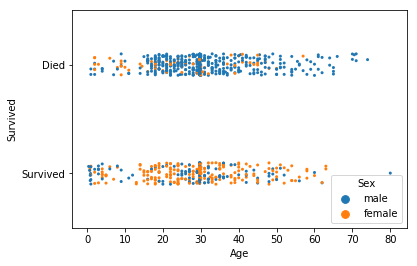

In [21]:
sns.stripplot(x='Age', y='Survived', hue='Sex', data = train_data_clean, jitter=True, size = 3)
plt.show()

The following boxplot shows that passenger class is indeed significant.

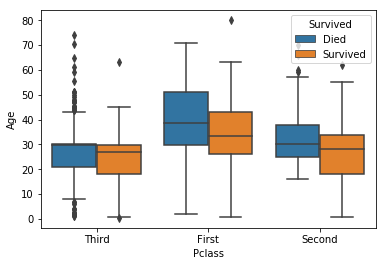

In [22]:
sns.boxplot( x = 'Pclass', y = "Age" , hue = 'Survived' , data=train_data_clean)
plt.show()

### Now we will do the same for the testing dataset.

In [23]:
features_test = test_df[column_features].copy()

In [24]:
features_test.isnull().sum()

Pclass     0
Sex        0
Age       86
Fare       1
dtype: int64

In [25]:
median = features_test['Age'].sum()/(features_test['Age'].count())

In [26]:
median

30.272590361445783

In [27]:
features_test['Age'] = features_test['Age'].fillna(median)

Here, there was an invallid entry in the 'Fare' column as well, se we'll also have to clean that.

In [28]:
median_fare = features_test['Fare'].median()

In [29]:
median_fare

14.4542

In [30]:
features_test['Fare'] = features_test['Fare'].fillna(median_fare)

In [31]:
features_test['Sex'].replace(['female','male'],[0,1],inplace=True)

In [32]:
features_test.head()

,Pclass,Sex,Age,Fare
0,3,1,34.5,7.8292
1,3,0,47.0,7.0000
2,2,1,62.0,9.6875
3,3,1,27.0,8.6625
4,3,0,22.0,12.2875


In [33]:
features_test.isnull().sum()

Pclass    0
Sex       0
Age       0
Fare      0
dtype: int64

### Now we can proceed to applying some algorithms to the training dataset.

Now we need to do a little bit of thinking and decide which algorithm would be most suitable. *Unforutnately*, I do not have enough knowledge to make an informed choice, so I'll just try out a few algorithms and compare their efficiency.

In [34]:
target_train = target_train.as_matrix().ravel()

#### We can start with a linear SVM. Looks like a good idea, it doesn't seem unreasonable to have a decision hyperplane depending on age, sex, and passenger class. Let's see how it goes.

In [35]:
from sklearn.svm import LinearSVC

In [36]:
clf_LSVC = LinearSVC(random_state=0)

For now, we can try running the algorithm with the default parameters.

In [37]:
clf_LSVC.fit(features_train, target_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

Now that we have trained our classifier, we can predict the result for our testing dataset.

In [38]:
target_test_linear_SVM = clf_LSVC.predict(features_test)

#### We can also try out some other SVM options that scikit-learn offers.

In [39]:
from sklearn.svm import SVC

We can try out the rbf kernel.

In [40]:
clf_rbfSVC = SVC()

In [41]:
clf_rbfSVC.fit(features_train, target_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
target_test_rbf_SVM = clf_rbfSVC.predict(features_test)

And the poly kernel.

In [43]:
# clf_polySVC = SVC(kernel = 'poly', degree = 3, verbose = True)

In [44]:
# clf_polySVC.fit(features_train, target_train)

In [45]:
# target_test_poly_SVM = clf_polySVC.predict(features_test)

*Disclaimer: it took too long to load, probably I did something wrong, so I just commented it out.*

#### We can also try out random forest and extreme random forest.

In [46]:
from sklearn.tree import ExtraTreeClassifier

In [47]:
clf_ET = ExtraTreeClassifier()

In [48]:
clf_ET.fit(features_train, target_train)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [49]:
target_test_ET = clf_ET.predict(features_test)

#### Or, a cool-sounding algorithm called XGBoosting.

In [50]:
from xgboost import XGBClassifier

In [51]:
clf_XGB = XGBClassifier()

In [52]:
clf_XGB.fit(features_train, target_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
target_test_XGB = clf_ET.predict(features_test)

### Once we have created the target datasets for the test dataset, we export them into pandas dataframes and then append them to a dataframe consisting of passenger IDs.

In [54]:
result_id = test_df[['PassengerId']].copy()

In [55]:
target_test_linear_SVM = pd.DataFrame(target_test_linear_SVM)
target_test_rbf_SVM = pd.DataFrame(target_test_rbf_SVM)
target_test_ET = pd.DataFrame(target_test_ET)
target_test_XGB = pd.DataFrame(target_test_XGB)

In [56]:
result_linear_SVM = result_id.assign(Survived = target_test_linear_SVM)
result_rbf_SVM = result_id.assign(Survived = target_test_rbf_SVM)
result_ET = result_id.assign(Survived = target_test_ET)
result_XGB = result_id.assign(Survived = target_test_XGB)

Just try outputing one of them, to see whether it looks good.

In [57]:
result_linear_SVM.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Allright, looks nice. **We are done!** Now it only left to export the resulting dataframes to .csv files and upload them back to Kaggle.

In [58]:
result_linear_SVM.to_csv('result-linear-SVM.csv', index = False)
result_rbf_SVM.to_csv('result-rbf-SVM.csv', index = False)
result_ET.to_csv('result-ET.csv', index = False)
result_XGB.to_csv('result-XGB.csv', index = False)

# Comments

### Looking a bit back on this, I believe [this guide](https://www.csie.ntu.edu.tw/~r95162/guide.pdf) would have been very helpful. Overall, understanding how each algorithm/kernel works in theory helps much better and makes the process feel less like waving your hands in a dark room. 

### On a different note, probably a better decision in this case would have been to separate the test data into 'test' and 'train' and get feedback instantly, without having to submit to kaggle (and deal with submission caps).